In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
# from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.preprocessing import StandardScaler
from keras.optimizers import Adam
import glob as gb
import pandas as pd
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout



from sklearn.metrics import classification_report, confusion_matrix

In [17]:
path_test = '/kaggle/input/dataset1/Dataset/test'
path_train ='/kaggle/input/dataset1/Dataset/train'

In [18]:
#reach to images and see the numbers of images in each test folder
for folder in os.listdir(path_test):
    files = gb.glob(pathname=str(path_test + '/' + folder + '/*.jpg'))
    print(f'For test data, found {len(files)} in folder {folder}')


For test data, found 12 in folder Class (17)
For test data, found 12 in folder Class (13)


In [19]:
#reach to images and see the numbers of images in each train folder
for folder in os.listdir(path_train):
    files = gb.glob(pathname=str(path_train + '/' + folder + '/*.jpg'))
    print(f'For train data, found {len(files)} in folder {folder}')

For train data, found 52 in folder Class (17)
For train data, found 52 in folder Class (13)


In [20]:
#most repeated size in test file
size = []
for i in os.listdir(os.path.join(path_test)):
    files = gb.glob(pathname=str(os.path.join(path_test, i, '*.jpg')))
    
    for j in files:
        image = cv2.imread(j)
        size.append(image.shape)

pd.Series(size).value_counts()

(256, 256, 3)    24
Name: count, dtype: int64

In [21]:
#most repeated size in train file
size = []
for i in os.listdir(os.path.join(path_train)):
    files = gb.glob(pathname=str(os.path.join(path_train, i, '*.jpg')))
    
    for j in files:
        image = cv2.imread(j)
        size.append(image.shape)
pd.Series(size).value_counts()

(256, 256, 3)    104
Name: count, dtype: int64

In [22]:
#indexing files 
code = {'Class (13)':0 ,'Class (17)':1}
def getcode(n) :     
       for x , y in code.items() : 
        if n == y :             
                     return x

In [23]:
# Function to perform data augmentation using ImageDataGenerator
def augment_data(images, datagen, augment_factor=5):
    augmented_images = []

    for img in images:
        augmented_images.extend(datagen.flow(img, batch_size=1, shuffle=False)[0] for _ in range(augment_factor))

    return np.array(augmented_images)  

In [24]:
#resize images in test file and make labels
x_test = []
y_test = []  # Corrected variable name
img_size = 225

for i in os.listdir(path_test):
    files = gb.glob(pathname=str(os.path.join(path_test, i, '*.jpg')))
    for j in tqdm(files):
        image = cv2.imread(j)
        image_array = cv2.resize(image, (img_size, img_size))
        x_test.append(list(image_array))
        y_test.append(code[i])  # Assuming code[i] provides the label for the class

# Convert to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Normalization x and Encoding y
# x_test = x_test / 255

print(x_test.shape)
print(y_test.shape)  # Corrected variable name


100%|██████████| 12/12 [00:00<00:00, 590.56it/s]

(24, 225, 225, 3)
(24,)


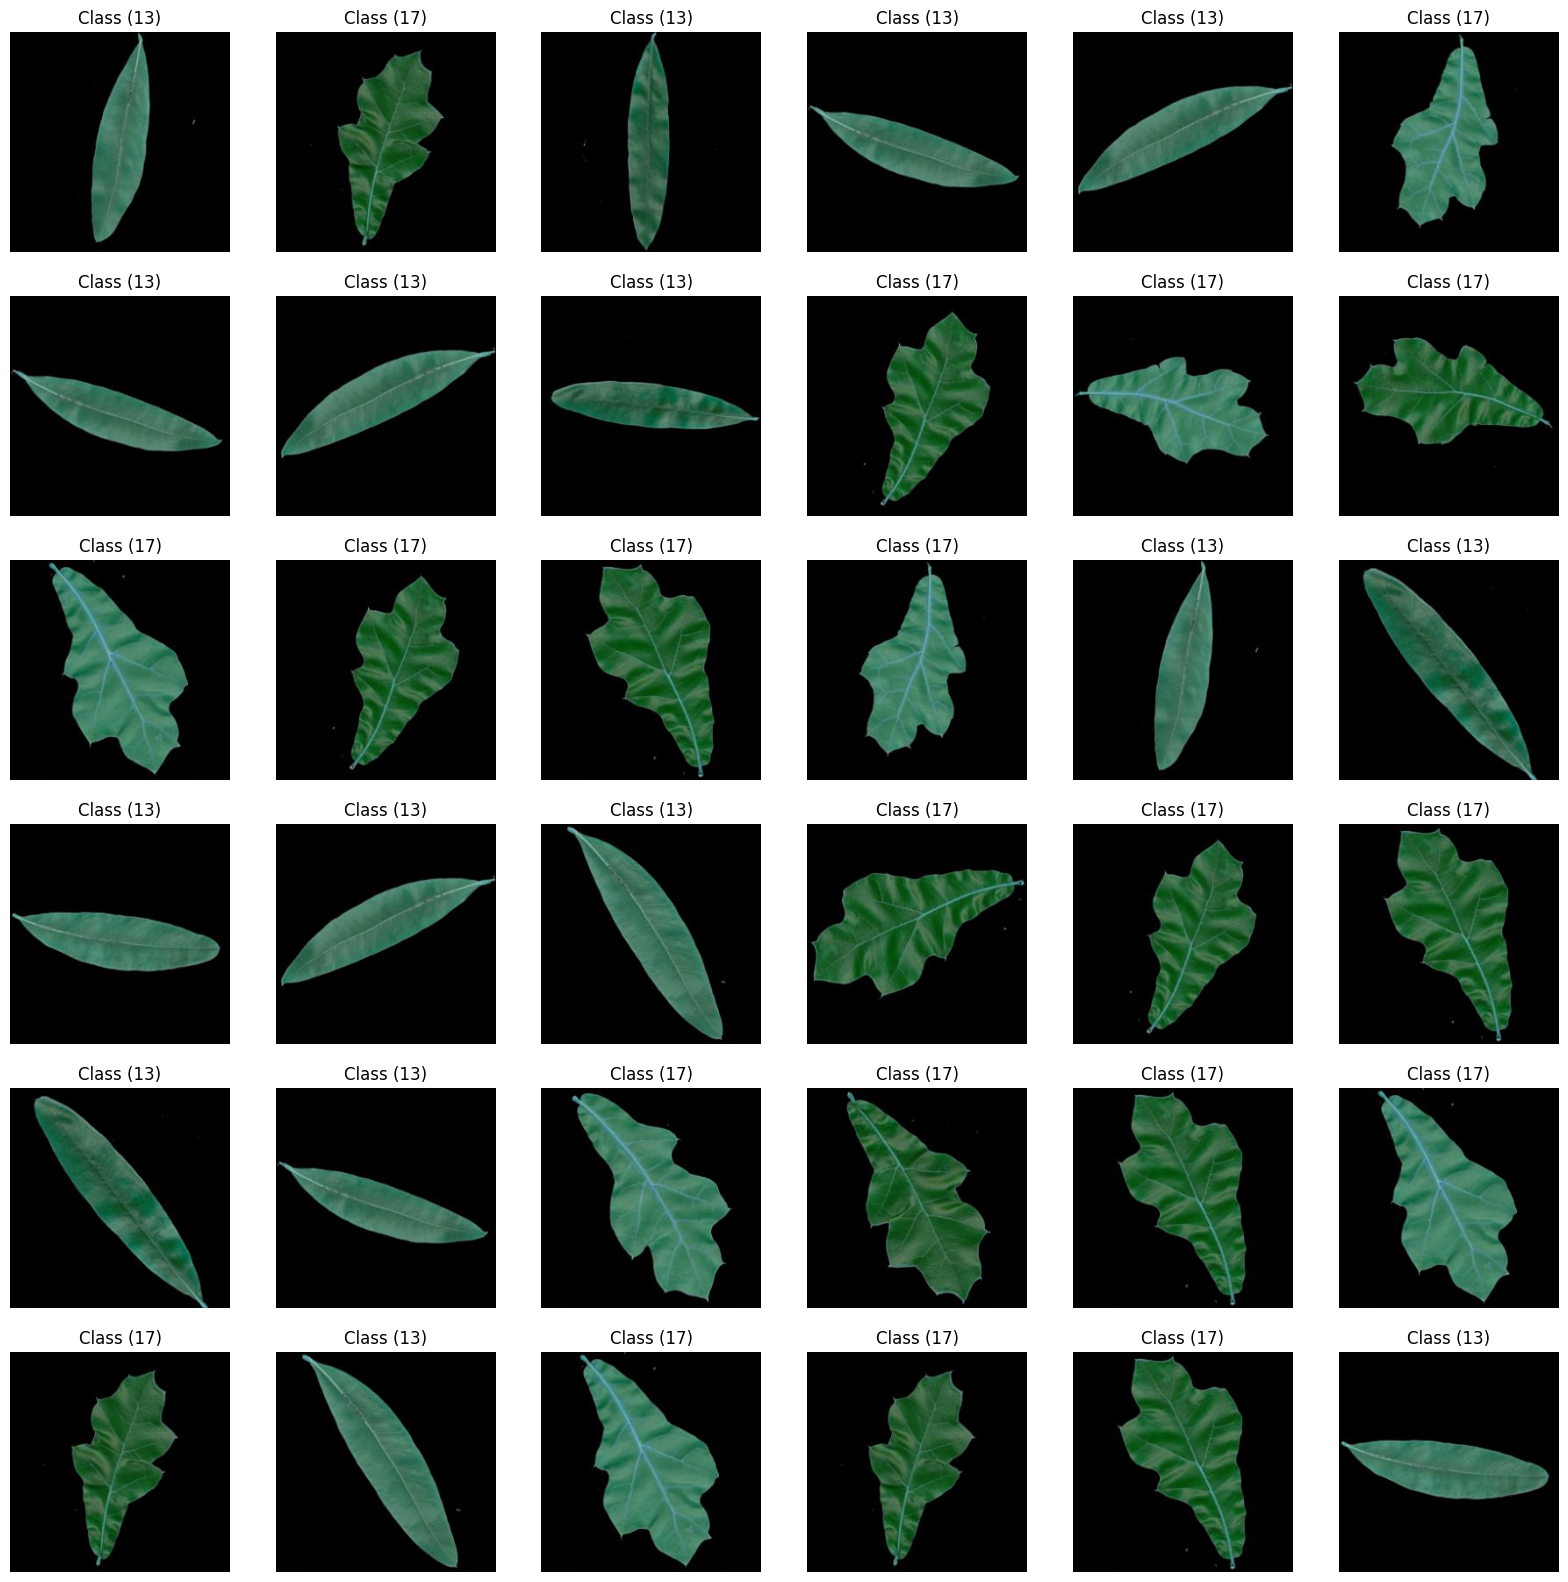

In [25]:
#display random images for x_test
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_test),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(x_test[i])   
    plt.axis('off')
    plt.title(getcode(y_test[i]))

In [26]:
#resize images in train file and make labels
x_train = []
y_train = []  # Corrected variable name
img_size = 225

for i in os.listdir(path_train):
    files = gb.glob(pathname=str(os.path.join(path_train, i, '*.jpg')))
    
    for j in tqdm(files):
        image = cv2.imread(j)
        image_array = cv2.resize(image, (img_size, img_size))
        x_train.append(list(image_array))
        y_train.append(code[i])  # Assuming code[i] provides the label for the class

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
# Normalization x and Encoding y
x_train = x_train / 255

print(x_train.shape)
print(y_train.shape)  # Corrected variable name


100%|██████████| 52/52 [00:00<00:00, 617.06it/s]


(104, 225, 225, 3)
(104,)


In [27]:
#agumentation
x_train_augmented = []
y_train_augmented = []

# First ImageDataGenerator with rotation, shift, shear, zoom, and flip
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Additional ImageDataGenerator with different augmentation settings
additional_datagen = ImageDataGenerator(
    brightness_range=[0.5, 1.5],
    channel_shift_range=90
)

for i in os.listdir(path_train):
    files = gb.glob(pathname=str(os.path.join(path_train, i, '*.jpg')))

    for j in tqdm(files):
        image = cv2.imread(j)
        image_array = cv2.resize(image, (img_size, img_size))
        augmented_images_first = augment_data([image_array[np.newaxis, ...]], datagen, augment_factor=5)
        x_train_augmented.extend(augmented_images_first)
        y_train_augmented.extend([code[i]] * len(augmented_images_first))
        augmented_images_additional = augment_data([image_array[np.newaxis, ...]], additional_datagen, augment_factor=7)
        x_train_augmented.extend(augmented_images_additional)
        y_train_augmented.extend([code[i]] * len(augmented_images_additional))
#Convert augmented data to numpy arrays
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)
# Remove the singleton dimension
x_train_augmented = np.squeeze(x_train_augmented, axis=1)

100%|██████████| 52/52 [00:03<00:00, 13.63it/s]


In [28]:
print("Original Training Data Shapes:", x_train.shape, y_train.shape)
print("Augmented Training Data Shapes:", x_train_augmented.shape, y_train_augmented.shape)
print("Testing Data Shapes:", x_test.shape, y_test.shape)

Original Training Data Shapes: (104, 225, 225, 3) (104,)
Augmented Training Data Shapes: (1248, 225, 225, 3) (1248,)
Testing Data Shapes: (24, 225, 225, 3) (24,)


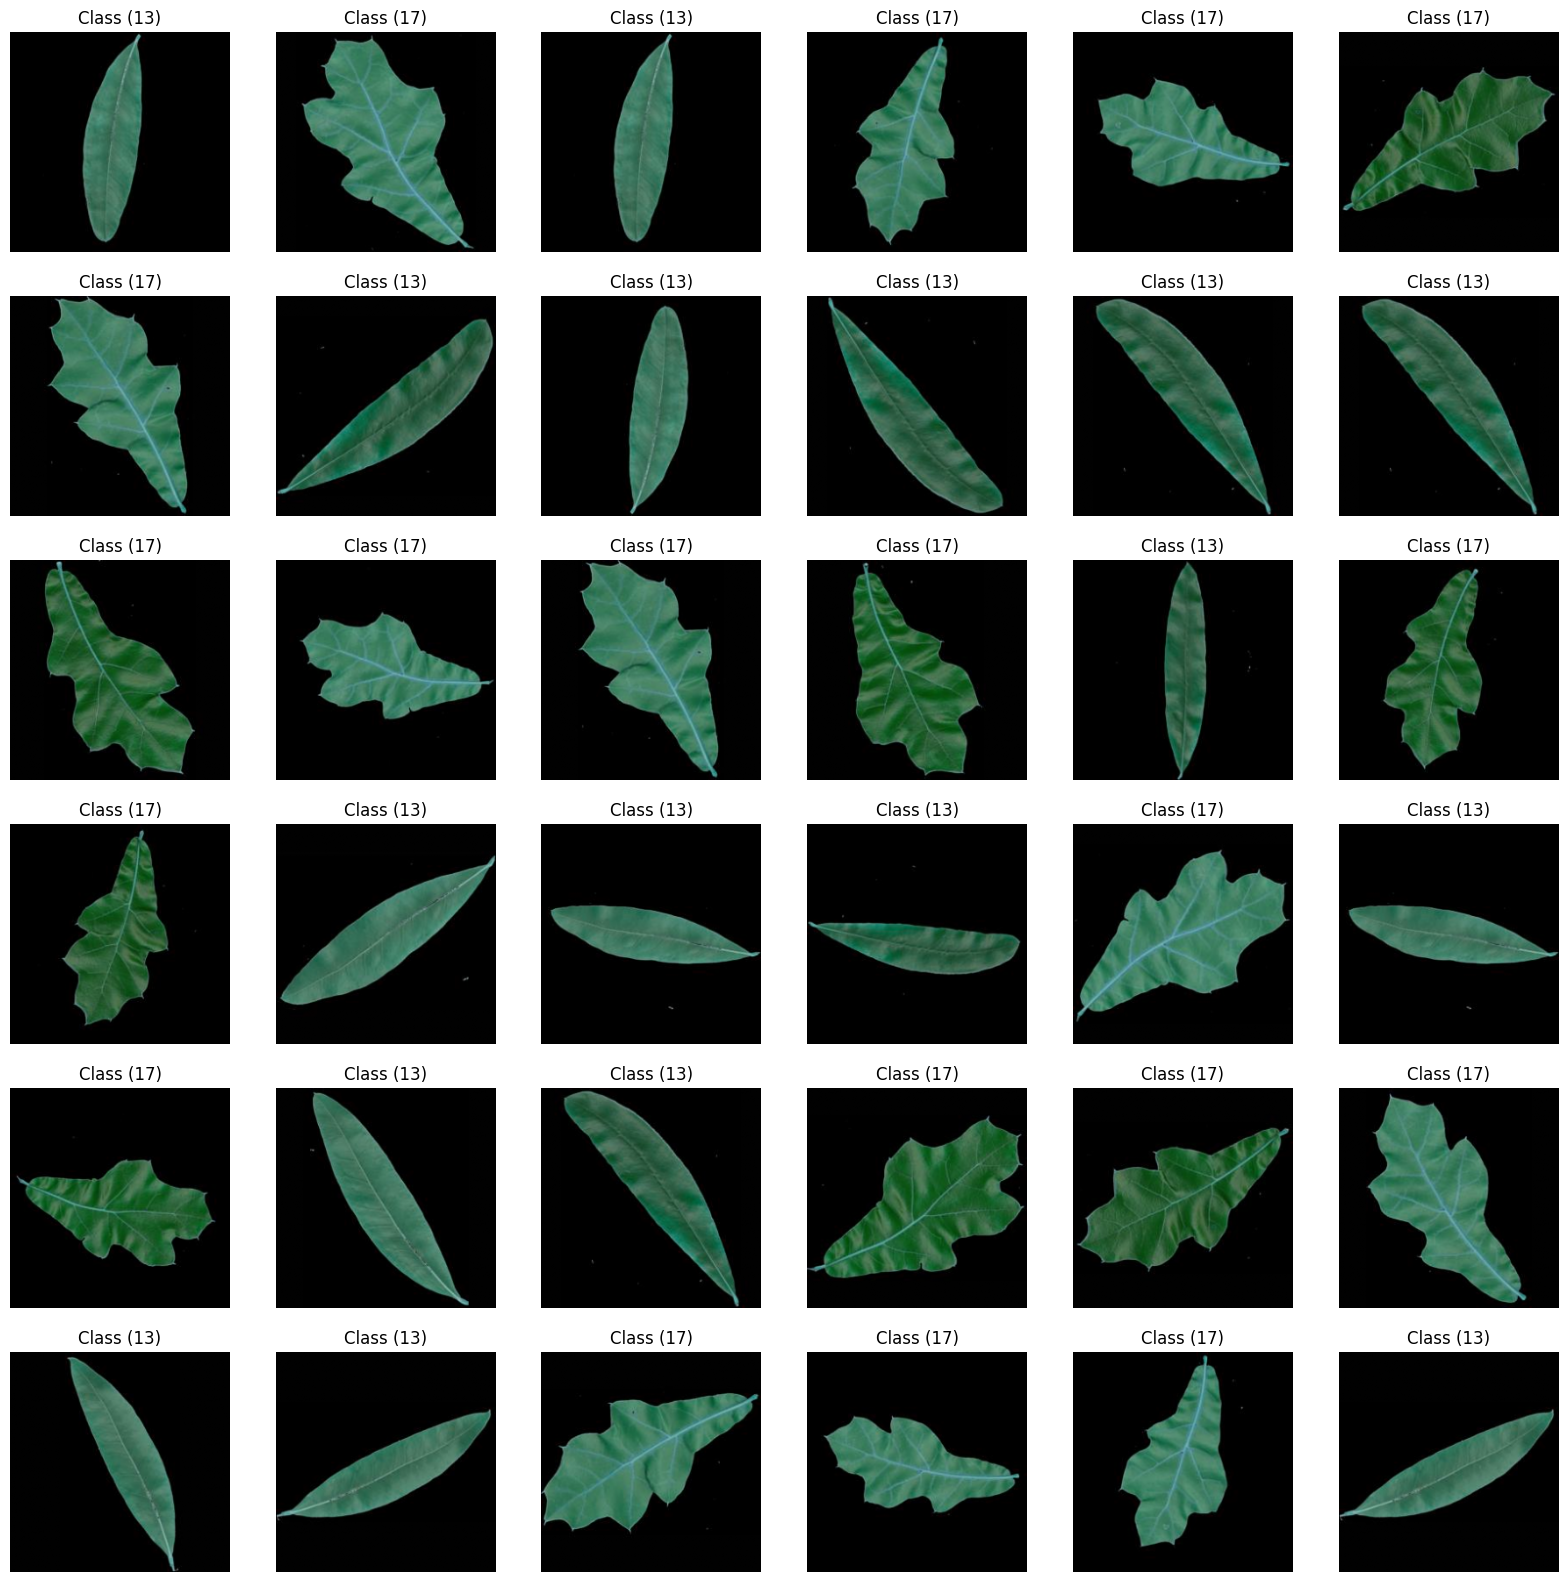

In [29]:
#display random images for x_train
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_train),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(x_train[i])   
    plt.axis('off')
    plt.title(getcode(y_train[i]))

In [30]:
# Model definition
img_size = 225
resnet_model = Sequential()
pretrained_model = ResNet152(include_top=False, input_shape=(img_size, img_size, 3), pooling=None, weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False
resnet_model.add(pretrained_model)

# Add Conv2D layer with MaxPooling2D
resnet_model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
resnet_model.add(MaxPooling2D(pool_size=(2, 2)))
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.7))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.6))  
resnet_model.add(Dense(40, activation='relu'))
resnet_model.add(Dropout(0.9))
resnet_model.add(Dense(1000, activation='relu'))
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(900, activation='relu'))
resnet_model.add(Dropout(0.6))
resnet_model.add(Dense(1, activation='sigmoid'))

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Model training
resnet_model.fit(x_train_augmented, y_train_augmented, validation_split=0.2, epochs=20, batch_size=62, callbacks=[early_stopping])

# Evaluate the model on the test set
evaluation = resnet_model.evaluate(x_test, y_test)

# Extracting metrics
accuracy = evaluation[1]
loss = evaluation[0]

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Make predictions on the test set
y_pred = resnet_model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming binary classification

# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, zero_division=1))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

# Analyze the results
if accuracy > 0.80:
    print("The model performed well on the test set.")
else:
    print("The model performed  is not well on the test set.")


Epoch 1/20
17/17 [==============================] - 29s 574ms/step - loss: 1.3886 - accuracy: 0.5541 - val_loss: 0.7093 - val_accuracy: 0.1240
Epoch 2/20
17/17 [==============================] - 5s 314ms/step - loss: 0.7951 - accuracy: 0.5822 - val_loss: 0.7678 - val_accuracy: 0.0000e+00
Epoch 3/20
17/17 [==============================] - 5s 311ms/step - loss: 0.6781 - accuracy: 0.6002 - val_loss: 0.8335 - val_accuracy: 0.0000e+00
Epoch 4/20
17/17 [==============================] - 5s 312ms/step - loss: 0.5343 - accuracy: 0.6222 - val_loss: 0.7954 - val_accuracy: 0.0000e+00
Epoch 5/20
17/17 [==============================] - 5s 312ms/step - loss: 0.4451 - accuracy: 0.6413 - val_loss: 0.6748 - val_accuracy: 0.9960
Epoch 6/20
17/17 [==============================] - 5s 312ms/step - loss: 0.3463 - accuracy: 0.8447 - val_loss: 0.5929 - val_accuracy: 1.0000
Epoch 7/20
17/17 [==============================] - 5s 312ms/step - loss: 0.2673 - accuracy: 0.9259 - val_loss: 0.4764 - val_accuracy: 